In [1]:
using RegionTrees
import RegionTrees: AbstractRefinery, needs_refinement, refine_data
using StaticArrays: SVector
using SparseArrays
using Plots

In [2]:
function plot_qtree(root)
    plt = plot(xlim=(0, 1), ylim=(0,1), legend=nothing)
    for leaf in allleaves(root)
        v = hcat(collect(vertices(leaf.boundary))...)
        plot!(plt, v[1,[1,2,4,3,1]], v[2,[1,2,4,3,1]])
    end
    plt
end

plot_qtree (generic function with 1 method)

In [3]:
# A circle in the middle at some val 1
function initial_state(x,y)
    if (x-0.5)^2 + (y-0.5)^2 < 0.2^2
        return 1
    else
        return 0
    end
end

initial_state (generic function with 1 method)

In [4]:
struct MyRefinery <: AbstractRefinery
    maxderiv
    minwidth
end

In [19]:
function needs_refinement(mr::MyRefinery, cell::Cell{Float64, 2, Float64, 4})
    # Don't refine if at the finest resolution
    if cell.boundary.widths[1] <= mr.minwidth
        return false
    end

    # Loop through the vertices, check derive compared to neighbor
    verts = vertices(cell)
    for i in 1:4
        x1,y1 = verts[i]
        x2,y2 = verts[(i%4)+1]
        deriv = abs(initial_state(x1,y1) - initial_state(x2,y2))/cell.boundary.widths[1]
        if deriv > mr.maxderiv
            return true
        end
    end
    false
end

needs_refinement (generic function with 2 methods)

In [6]:
function refine_data(::MyRefinery, ::Cell, indices)
    0.0
end

refine_data (generic function with 2 methods)

In [95]:
function find_position_idx(node)
    # Find which direction this child is
    # 1 -> SW -> 1,1
    # 2 -> SE -> 2,1
    # 3 -> NW -> 1,2
    # 4 -> NE -> 2,2
    idx = 0
    for i in 1:2, j in 1:2
        idx = j +(i-1)*2
        if node == parent(node).children[i,j]
            return idx
        end
    end
    0
end

find_position_idx (generic function with 1 method)

In [125]:
function north_nearest_neighbor(node)
    # If it's the root, no neighbor
    if parent(node) == nothing
        return nothing
    end
    idx = find_position_idx(node)
    # If it's a south child, return the north child
    if idx == 1
        return parent(node).children[1,2]
    end
    if idx == 2
        return parent(node).children[2,2]
    end
    # If its a north child, get the north neighbor of the parent
    v = north_nearest_neighbor(parent(node))
    # If the parent north neighbor doesn't have children, or doesn't exist, return it
    if v == nothing || isleaf(v)
        return v
    else
        # Return the matching south child of the parent north neighbor
        if idx == 3 # West
            return v.children[1,1]
        else        # East
            return v.children[2,1]
        end
    end
end

north_nearest_neighbor (generic function with 1 method)

In [106]:
function south_nearest_neighbor(node)
    # If it's the root, no neighbor
    if parent(node) == nothing
        return nothing
    end
    idx = find_position_idx(node)
    # If its a north child, return the south child
    if idx == 3
        return parent(node).children[1,1]
    end
    if idx == 4
        return parent(node).children[2,1]
    end
    # If it's a south child, get the south neighbor of the parent
    v = south_nearest_neighbor(parent(node))
    if v == nothing || isleaf(v)
        return v
    else
        # Return the matching north child of the parent south neigbor
        if idx == 1
            return v.children[1,2]
        else
            return v.children[2,2]
        end
    end
end

south_nearest_neighbor (generic function with 1 method)

In [107]:
function east_nearest_neighbor(node)
    # If it's the root, no neighbor
    if parent(node) == nothing
        return nothing
    end
    idx = find_position_idx(node)
    # if its a west child, return the east child
    if idx == 1
        return parent(node).children[2,1]
    end
    if idx == 3
        return parent(node).children[2,2]
    end
    # If it's an east child, get the east neighbor of the parent
    v = east_nearest_neighbor(parent(node))
    if v == nothing || isleaf(v)
        return v
    else
        # Return the matching west child of the parent east neighbor
        if idx == 2
            return v.children[1,1]
        else
            return v.children[1,2]
        end
    end
end

east_nearest_neighbor (generic function with 1 method)

In [113]:
function west_nearest_neighbor(node)
    # If it's the root, no neighbor
    if parent(node) == nothing
        return nothing
    end
    idx = find_position_idx(node)
    # if it's an east child, return the west child
    if idx == 2
        return parent(node).children[1,1]
    end
    if idx == 4
        return parent(node).children[1,2]
    end
    # If it's a west child, return the west neighbor of the parent
    v = west_nearest_neighbor(parent(node))
    if v == nothing || isleaf(v)
        return v
    else
        # Return the matching east child of the parent west neighbor
        if idx == 1
            return v.children[2,1]
        else
            return v.children[2,2]
        end
    end
end

west_nearest_neighbor (generic function with 1 method)

In [131]:
function balance_quad_tree(root)
    queue = collect(allleaves(root))
    println("queue starting with $(length(queue)) elements")
    while !isempty(queue)
        # Get the next cell to check
        node = pop!(queue)
        # Start checking if it needs to split, assume no at the start
        needs_to_split = false
        # Get the nearest neighbors and check them
        # if it has adjacent children that aren't leaves We have to split.
        # If we find we have to split, we can skip searching the other neighbors
        nn = north_nearest_neighbor(node)
        if nn != nothing && nn.children != nothing && (!isleaf(nn.children[1,1]) || !isleaf(nn.children[2,1]))
            needs_to_split = true
        end
        sn = south_nearest_neighbor(node)
        if !needs_to_split && sn != nothing && sn.children != nothing && (!isleaf(sn.children[1,2]) || !isleaf(sn.children[2,2]))
            needs_to_split = true
        end
        en = east_nearest_neighbor(node)
        if !needs_to_split && en != nothing && en.children != nothing && (!isleaf(en.children[1,1]) || !isleaf(en.children[1,2]))
            needs_to_split = true
        end
        wn = west_nearest_neighbor(node)
        if !needs_to_split && wn != nothing && wn.children != nothing && (!isleaf(wn.children[2,1]) || !isleaf(wn.children[2,2]))
            needs_to_split = true
        end

        if needs_to_split
            split!(node)
            # Add new leaves to the queue
            vcat(queue, reshape(collect(node.children), 4))
            # Check if neightbor now needs to split
            if nn.boundary.widths[1] > node.boundary.widths[1]
                append!(queue, nn)
            end
            if sn.boundary.widths[1] > node.boundary.widths[1]
                append!(queue, sn)
            end
            if en.boundary.widths[1] > node.boundary.widths[1]
                append!(queue, en)
            end
            if wn.boundary.widths[1] > node.boundary.widths[1]
                append!(queue, wn)
            end
        end
    end
end

balance_quad_tree (generic function with 1 method)

In [93]:
function quadtree_to_sparse_array(root)
    # Secret tool that will help us later (it maps counting the four children to their proper corner index)
    idx_map = Dict(1=>2,2=>4,3=>1,4=>3)

    # Initialize the array
    # Get the smallest stride (finest resolution)
    stride = minimum([leaf.boundary.widths for leaf in allleaves(root)])[1]
    # number of squares per dimension of the matrix
    dim = Int(1/stride)
    # Create the array, 1+num squares for the points
    arr = spzeros(dim+1,dim+1)

    # Iterate over the quadtree and add nodes to the array
    for cell in allcells(root)
        if !isleaf(cell)
            # Add centerpoints
            x,y = (Int.(dim*RegionTrees.center(cell)) .+ 1)
            j = x
            i = (dim+2)-y
            arr[i,j] = 1
            # Add midpoints from child divisions
            for (idx,val) in enumerate(cell.children)
                x,y = (Int.(dim*vertices(val)[idx_map[idx]]).+1)
                j = x
                i = (dim+2)-y
                arr[i,j] = 1
                # arr[(Int.(dim*vertices(val)[idx_map[idx]]).+1)...] = 1
            end
        end
    end
    # Add the corners of the root node
    for (idx,val) in enumerate(vertices(root))
        x,y = (Int.(dim*val).+1) 
        j = x
        i = (dim+2)-y
        arr[i,j] = 1
        # arr[(Int.(dim*val).+1)...] = 1
    end
    arr
end


quadtree_to_sparse_array (generic function with 1 method)

## Testing it out

In [134]:
# Generate the base quadtree
# The input domain will always be 0-1
root = Cell(SVector(0., 0), SVector(1.,1),0.0)
# Split out to the default resolution (1/16, 1/2^3)
f(a,b) = 0.0
split!(root)                # 1/2
for leaf in allleaves(root) # 1/4
    split!(leaf,f)
end
for leaf in allleaves(root) # 1/8
    split!(leaf,f)
end
for leaf in allleaves(root) # 1/16
    split!(leaf,f)
end

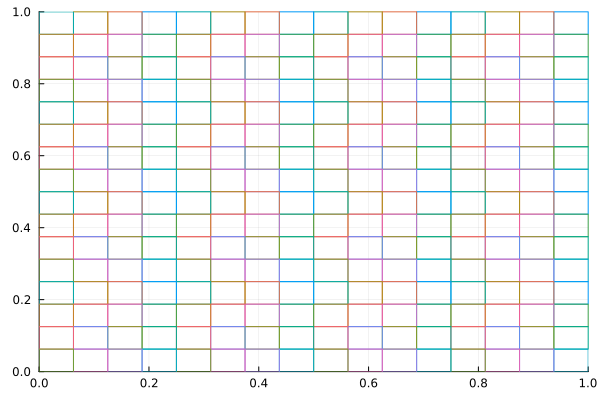

In [135]:
plot_qtree(root)

In [136]:
boundary = RegionTrees.HyperRectangle(SVector(0., 0), SVector(1., 1))
refinery = MyRefinery(0.3,1/(2^6))
# root = RegionTrees.Cell(boundary, 0.0)

refinery = MyRefinery(0.3,1/(2^6))
for leaf in allleaves(root)
    adaptivesampling!(leaf, refinery)
end

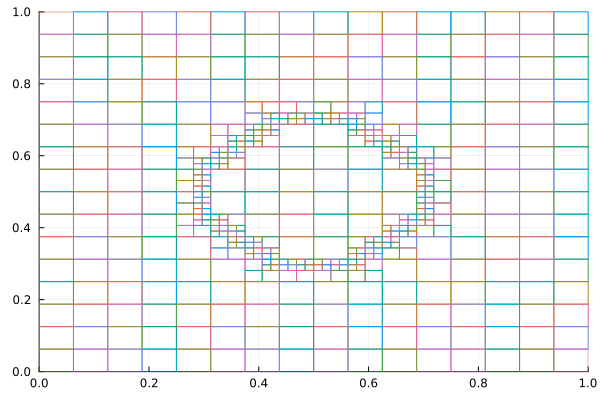

In [137]:
plot_qtree(root)

In [138]:
balance_quad_tree(root)

queue starting with 496 elements


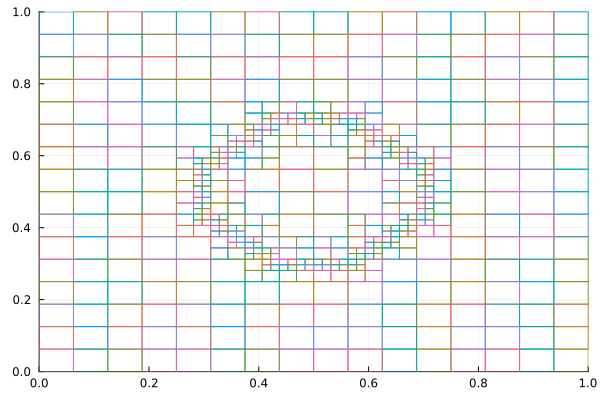

In [139]:
plot_qtree(root)

In [140]:
quadtree_to_sparse_array(root)

65×65 SparseMatrixCSC{Float64, Int64} with 641 stored entries:
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠅⣥⣥⣥⣥⣥⣥⡅⠅⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠅⣥⣿⡿⠏⠍⠍⠍⠿⣿⣧⡅⠅⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠅⣥⣿⡿⠏⠅⠅⠁⠁⠁⠅⠍⠿⣿⣧⡅⠅⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠅⣿⡏⠅⠅⠁⠁⠀⠁⠀⠁⠁⠅⠍⣿⡇⠅⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠅⣿⡇⠅⠅⠀⠁⠀⠁⠀⠁⠀⠅⠅⣿⡇⠅⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠅⠿⣿⣧⡅⠅⠅⠀⠁⠀⠅⠅⣥⣿⡿⠇⠅⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠁⠍⠿⣿⣧⡅⠅⠅⠅⣥⣿⡿⠏⠅⠁⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠁⠍⠿⠿⠿⠿⠿⠿⠏⠅⠁⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠁⠁⠁⠁⠁⠁⠁⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁

In [63]:
test = Cell(boundary,0.0)
split!(test)
for i in 1:2, j in 1:2
    idx = j +(i-1)*2
    if test.children[2,1] == test.children[i,j]
        println("id = $(idx)")
    end
    # println(test.children[i,j], idx)
end
# 1 -> SW
# 2 -> SE
# 3 -> NW
# 4 -> NE

id = 3
